# Ejemplo básico: Random Forest con Iris

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

iris = pd.read_csv("iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [37]:
# En este ejemplo trabajamos con todas las features
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
# La target sí puede ser categórica, no hace falta transformarla
target = 'species'

X = iris[features].copy()
y = iris[target]

In [38]:
# Dividimos antes de entrenar
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 20% test
    random_state=42,     # reproducibilidad
    stratify=y           # mantener proporción de clases
)

In [39]:
# Diccionario de hiperparámetros (solo C y max_iter, como en Titanic)
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "max_iter": [300]
}

In [40]:
# Modelo base de Regresión Logística para multiclase
log_reg = LogisticRegression(
    multi_class="multinomial",  # Indicamos que queremos clasificar más de dos clases (Iris tiene 3)
                                # podríamos omitirlo para que no salga el warning
    solver="lbfgs"              # Algoritmo recomendado para problemas multiclase.
                                # Es estable, rápido y funciona bien con "multinomial".
)

In [41]:
# Configuración del GridSearch
grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

# Entrenar el GridSearch
grid.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid.best_params_)

# Mejor modelo ya entrenado
best_model = grid.best_estimator_

Mejores hiperparámetros: {'C': 1, 'max_iter': 300}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Análisis de overfitting / underfitting

Evaluamos con métricas si realmente hay overfitting o underfitting:

In [42]:
# Accuracy en entrenamiento
train_acc = best_model.score(X_train, y_train)

# Accuracy en test
test_acc = best_model.score(X_test, y_test)

print("Accuracy TRAIN:", train_acc)
print("Accuracy TEST :", test_acc)

Accuracy TRAIN: 0.975
Accuracy TEST : 0.9666666666666667


**Conclusión**

El modelo obtiene un rendimiento excelente: la accuracy en entrenamiento (97.5%) y la accuracy en test (96.7%) son muy altas y prácticamente iguales.

Esto indica que la Regresión Logística multiclase ha aprendido patrones claros en el dataset Iris sin sobreajustar.

La diferencia mínima entre train y test muestra que el modelo generaliza muy bien y que los datos son linealmente separables en gran medida.



## Análisis de atributos útiles

In [43]:
# Coeficientes del modelo

# Cada fila de coef_ corresponde a una clase (en el mismo orden que best_model.classes_)
# Cada columna corresponde a una feature
coef_df = pd.DataFrame(
    best_model.coef_,
    index=best_model.classes_,   # nombres de las clases (setosa, versicolor, virginica)
    columns=X_train.columns      # nombres de las variables
)

coef_df

,sepal_length,sepal_width,petal_length,petal_width
setosa,-0.529620,0.827358,-2.347263,-0.993463
versicolor,0.529727,-0.304866,-0.170965,-0.856158
virginica,-0.000107,-0.522492,2.518228,1.849621


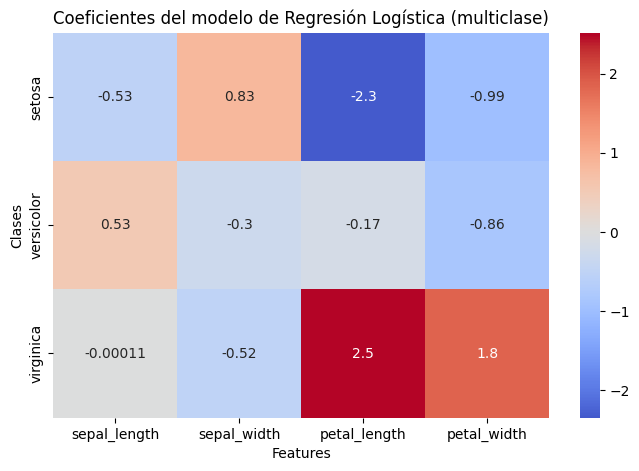

In [44]:
plt.figure(figsize=(8,5))
sns.heatmap(
    coef_df,
    annot=True,          # mostrar valores numéricos
    cmap="coolwarm",     # azul = negativo, rojo = positivo
    center=0             # que los colores se centren en 0, ideal para interpretar coeficientes
)

plt.title("Coeficientes del modelo de Regresión Logística (multiclase)")
plt.xlabel("Features")
plt.ylabel("Clases")
plt.show()

**Interpretación del gráfico anterior**

* Filas → cada especie (setosa, versicolor, virginica)

* Columnas → cada una de las 4 features

* Color rojo → coeficiente positivo → aumenta probabilidad de esa clase

* Color azul → coeficiente negativo → reduce probabilidad de esa clase

Más intenso = mayor impacto

**Conclusiones**:

* Las **variables del pétalo** (`petal_length` y `petal_width`) son las que más influyen en la clasificación de las flores: sus coeficientes son los más grandes tanto en positivo como en negativo.

* Para **setosa**, los coeficientes de pétalo son fuertemente negativos, lo que significa que **setosa aparece cuando los pétalos son pequeños**. Esto coincide con la realidad del dataset.

* **Virginica** muestra coeficientes muy positivos en `petal_length` y `petal_width`, indicando que **valores grandes de estas medidas aumentan mucho la probabilidad de virginica**.

* **Versicolor** queda en una zona intermedia, con coeficientes moderados en todas las variables, lo que refleja que es la especie “intermedia” entre setosa y virginica.

* Las variables del sépalo (`sepal_length` y `sepal_width`) también influyen, pero **mucho menos** que las del pétalo. Sus coeficientes son más pequeños y tienen menor impacto en la decisión final.

## Evaluación del modelo

In [45]:
# Predicciones finales
y_pred = best_model.predict(X_test)

In [46]:
# Accuracy final
acc = accuracy_score(y_test, y_pred)
print("\nAccuracy final en test:", acc)


Accuracy final en test: 0.9666666666666667


**Conclusión**:

El modelo alcanza una accuracy del 96.67% en el conjunto de test, lo que indica un rendimiento excelente.

La Regresión Logística multiclase ha sido capaz de separar muy bien las tres especies del iris y generaliza correctamente a datos nuevos. Funciona de forma estable y aprovecha que las clases en Iris están muy bien delimitadas por sus características.

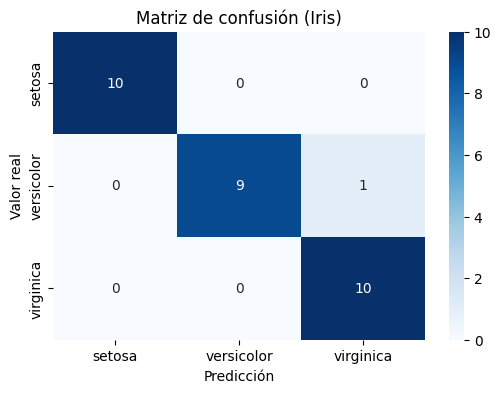

In [47]:
# Matriz de confusión multiclase
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

# Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)

plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de confusión (Iris)")
plt.show()

La matriz de confusión muestra un rendimiento casi perfecto: el modelo acierta todas las muestras de setosa y virginica, y solo confunde un único caso de versicolor con virginica.

Esto confirma que la Regresión Logística distingue muy bien las tres especies en el dataset Iris.
